<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Lab 02 - TRỰC QUAN HOÁ DỮ LIỆU 📌
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Giai đoạn 3 - Data Modelling 📌
</div>

### Nhập các thư viện cần thiết

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime, date

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings

warnings.simplefilter('ignore')

### Đọc dữ liệu

In [2]:
data = pd.read_csv('./data/Water_Cleaner_2.csv', parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
data = data.iloc[:, :-3]

# Modelling 

***Time Series*** có thể là `Đơn biến(Univariate)` hoặc `Đa biến(Multivariate)`:
- **Univariate Time Series:** Chỉ có một biến phụ thuộc vào thời gian. 
- **Multivariate Time Series:** Có nhiều biến phụ thuộc vào thời gian. 

Dữ liệu trong được sử dụng trong Lab này là Multivariable Time Series Data. 

$\rightarrow$ Dựa theo mục đích của tập dữ liệu này, **target** đã được chọn trong `1.0_Preprocessing` là ***Depth_to_Groundwater***, tức dự đoán mức nước ngầm để có thể chuẩn bị biện pháp bảo vệ nguồn nước.

$\rightarrow$ Có thể chuyển đổi **Multivariable Time Series Data** $\rightarrow$ **Univariable Time Series Data**

Nhóm chọn `chia dữ liệu theo quý` để có thể dự đoán, lập kế hoạch và quyết định chuẩn bị một cách tốt nhất.

- Dữ liệu kéo dài từ `1-1-2009` đến `25-6-2020`, tức `46 quý`.

- Sử dụng quý cuối - `46`, tức quý 2 thuộc năm 2020 để làm `tập test`.

- Phần còn lại sử dụng là `tập train` cho model.

In [5]:
df1 = data.copy()
df1['quarter'] = pd.PeriodIndex(df1['Date'], freq='Q')
df1['quarter_idx'] = (df1['quarter'] != df1['quarter'].shift(1)).cumsum()

target = 'Depth_to_Groundwater'
features = [feature for feature in df1.columns if feature != target]

N_SPLITS = 46

# Tập train không bao gồm quý cuối cùng
X = df1[df1.quarter_idx < N_SPLITS][features]
y = df1[df1.quarter_idx < N_SPLITS][target]

# Tập test là quý cuối - 46
X_test = df1[df1.quarter_idx == N_SPLITS][features].reset_index(drop=True)
y_test = df1[df1.quarter_idx == N_SPLITS][target].reset_index(drop=True)


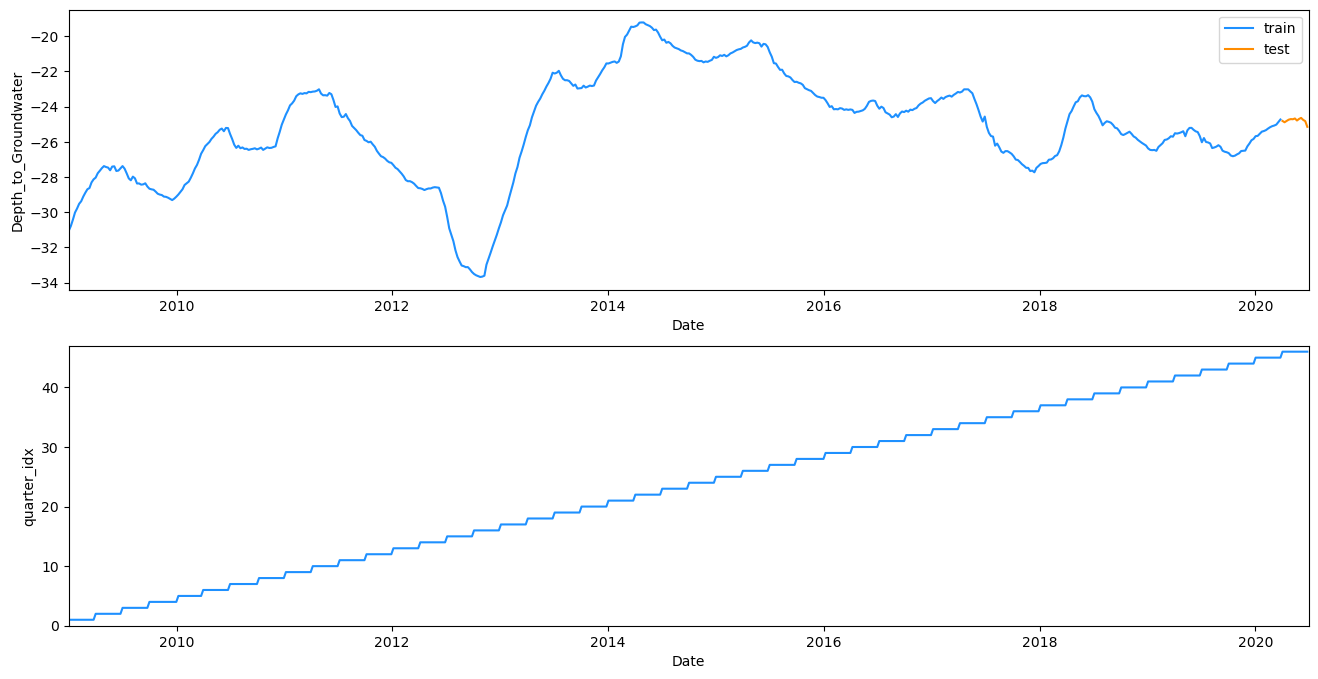

In [6]:
folds = np.linspace(0, N_SPLITS - 3, num=N_SPLITS - 2)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Vẽ biểu đồ cho dữ liệu huấn luyện và kiểm tra
sns.lineplot(x=X['Date'], y=y, ax=ax[0], color='dodgerblue', label='train')
sns.lineplot(x=X_test['Date'], y=y_test, ax=ax[0], color='darkorange', label='test')

# Vẽ biểu đồ chỉ số quý theo thời gian
sns.lineplot(x=df1['Date'], y=df1['quarter_idx'], ax=ax[1], color='dodgerblue')

# Đặt giới hạn cho trục x và trục y
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_ylim([0, N_SPLITS + 1])

plt.show()

**Hàm vẽ biểu đồ dựa trên Fold**

In [7]:
def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    
    # Vẽ dữ liệu huấn luyện, giá trị thực và giá trị dự đoán
    sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    
    # Thiết lập trục x và y cho biểu đồ dự đoán
    ax[0].set_xlim([date(2018, 6, 30), date(2020, 6, 30)])
    ax[0].set_ylim([-27, -23])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_test, y_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('Depth to Groundwater P25', fontsize=14)
    
    # Vẽ biểu đồ loss (MAE và RSME)
    sns.lineplot(x=folds, y=score_mae,  color='gold', label='MAE', ax=ax[1])
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    
    # Thiết lập trục cho biểu đồ loss
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel('Fold', fontsize=14)
    ax[1].set_ylabel('Loss', fontsize=14)
    ax[1].set_ylim([0, 4])
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

📌 ***Đánh giá mô hình***
Hai chỉ số được sử dụng để đánh giá hiệu suất dự báo là:
- **Mean Absolute Error (MAE)**: Giá trị tuyệt đối trung bình của sai số dự báo.

- **Root Mean Square Error (RMSE)**: Căn bậc hai của trung bình bình phương sai số dự báo.

Cả hai chỉ số này đều cho biết độ lệch giữa giá trị dự báo và giá trị thực tế. Chỉ số càng nhỏ thì mô hình dự báo càng tốt.

## 1. Models for Univariate Time Series - Mô hình hóa Đơn biến

### 1.1. Naive Approach

Là một phương pháp **dự báo cơ bản** và **không phức tạp**. 
- Phương pháp này thường dựa trên các **giả định đơn giản** và **không sử dụng các mô hình phức tạp hoặc các thuật toán phức tạp** để đưa ra dự đoán.

📌 Như mục tiêu, để dự đoán giá trị **Depth_to_Groundwater**, tức dự đoán mức nước ngầm theo chuỗi thời gian. 

$\rightarrow$ Phương pháp được sử dụng là: ***Naive Method***

- Giả định rằng giá trị dự báo cho kỳ tiếp theo bằng giá trị của kỳ hiện tại hoặc kỳ trước đó.

- Công thức: $\hat{y}_t+1 = y_t$
​
  - Trong đó:
    - $\hat{y}_t+1$ là giá trị dự báo cho kỳ. 
    - $y_t$ là giá trị quan sát ở kỳ.

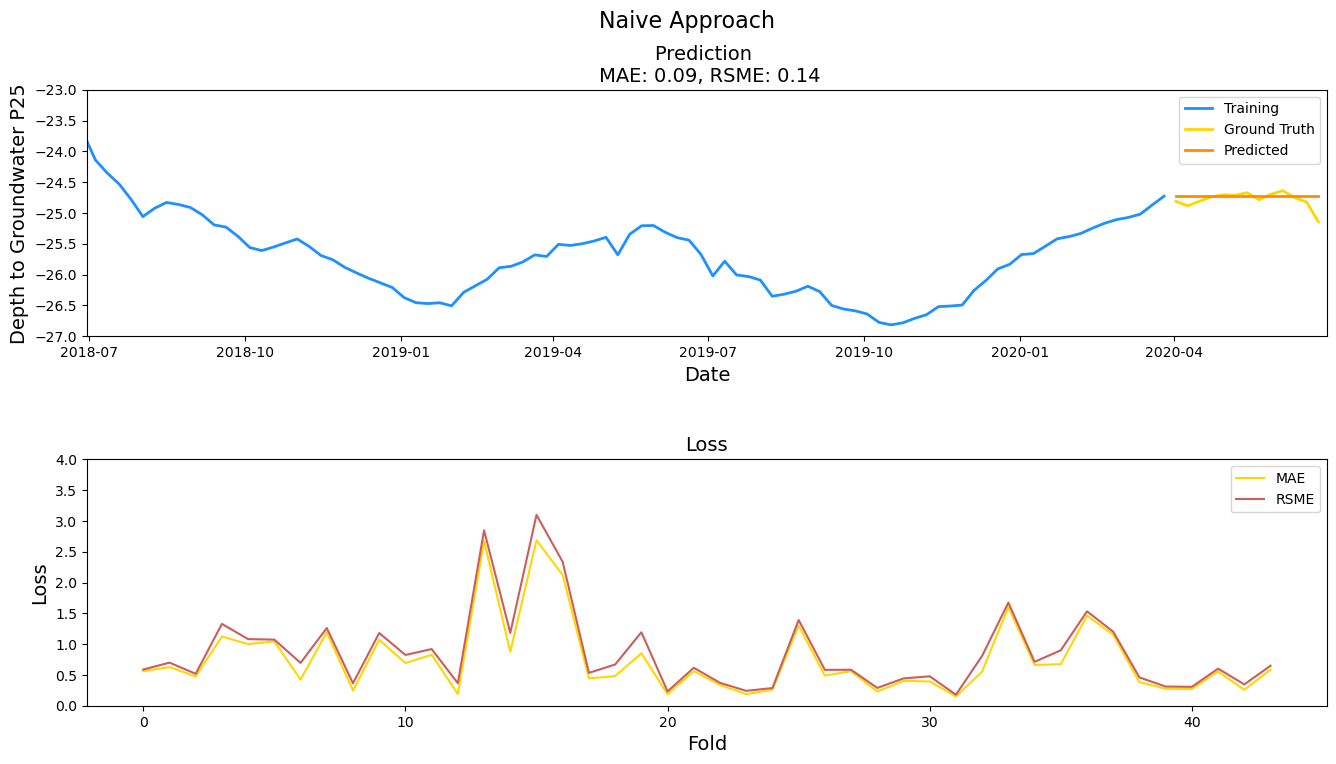

In [9]:
score_mae = []
score_rsme = []

for valid_quarter_id in range(2, N_SPLITS):
    train_index = df1[df1.quarter_idx < valid_quarter_id].index
    valid_index = df1[df1.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Dự báo theo phương pháp Naive
    y_valid_pred = pd.Series(np.full(len(y_valid), y_train.iloc[-1]))
    
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.full(len(X_test), y.iloc[-1]))

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Naive Approach')

**Nhận xét:**

- ***Biểu đồ dự đoán - Dự đoán Naive Approach:***
    - Đường dự đoán gần như là *một đường ngang*, thể hiện đặc tính của mô hình Naive Approach.
    - `MAE (0.09)` và `RMSE (0.14)` tương đối thấp, cho thấy sai số dự báo trung bình là khá nhỏ. Tuy nhiên, các chỉ số này có thể bị ảnh hưởng bởi các biến động lớn trong một số khoảng thời gian nhất định.
    - Điều này làm cho mô hình *không bắt được xu hướng hoặc biến động trong dữ liệu*, dẫn đến các dự đoán không phản ánh đúng sự biến động của dữ liệu thực tế.

- ***Biểu đồ loss - Loss (MAE và RSME):***
    - Biểu đồ mất mát (loss) và sai số (MAE, RMSE) cho thấy sự biến động khá lớn theo từng fold trong quá trình kiểm định chéo (cross-validation). Điều này có thể là do dữ liệu có tính chất *không ổn định* hoặc mô hình chưa đủ phức tạp để nắm bắt hết các đặc điểm của dữ liệu.
    - Các đỉnh cao trong biểu đồ mất mát và sai số thường tương ứng với các thời điểm mà mô hình dự báo kém chính xác hơn, như đã thấy trong biểu đồ trên.

**Đánh giá tổng quan:**
- Mô hình Naive Approach rất đơn giản và dễ triển khai, nhưng thường không đạt hiệu quả cao trong việc dự đoán dữ liệu thời gian vì nó không bắt được xu hướng và biến động trong dữ liệu.

- Kết quả từ biểu đồ cho thấy mô hình Naive Approach chỉ hữu ích trong các trường hợp rất đơn giản hoặc làm baseline để so sánh với các mô hình phức tạp hơn.


### 1.2. ARIMA

***ARIMA*** **(Autoregressive Integrated Moving Average - Trung bình di động tích hợp tự hồi quy)** được sử dụng để *phân tích* và *dự báo dữ liệu chuỗi thời gian*, và một trong những khía cạnh quan trọng mà nó mô tả chính là *tính tự tương quan* trong dữ liệu.

📌 ***Tính tự tương quan (Autocorrelation)*** là mối quan hệ giữa các giá trị của một chuỗi thời gian tại các thời điểm khác nhau. Nói cách khác, nó đo lường mức độ mà giá trị hiện tại của chuỗi thời gian phụ thuộc vào các giá trị quá khứ của nó.

$$
y_t = c + α_1 y_{t-1} + ... + α_p y_{t-p} + ε_t = c + \sum_{i=1}^{p} α_i y_{t-i} + ε_t -> p
$$

Mô hình này gồm **3 thành phần** chính:
- **Tự hồi quy (AR)**: Sử dụng các giá trị quá khứ của chuỗi thời gian để dự đoán giá trị hiện tại, nắm bắt các mối quan hệ tuyến tính giữa các quan sát.
    - Phần này biểu diễn mối quan hệ tuyến tính giữa giá trị hiện tại của chuỗi thời gian ($y_t$) và các giá trị quá khứ của nó ($y_{t−1}, y_{t_2}, \dots, y_{t−p}​$).
    - Công thức:
    $$
    y_t = c + \alpha_1 y_{t-1} + ... + \alpha_p y_{t-p} + \epsilon_t = c + \sum_{i=1}^{p} \alpha_i y_{t-i} + \epsilon_t \longrightarrow p
    $$
    - Trong đó:
        - $y_t$: Giá trị của chuỗi thời gian tại thời điểm $t$.
        - $c$: Hằng số.
        - $\alpha_1, \dots, \alpha_p$: Các hệ số của mô hình AR.
        - $p$: Bậc của mô hình AR (số lượng giá trị quá khứ được sử dụng).
        - $\epsilon_t$: Sai số ngẫu nhiên tại thời điểm $t$.

- **Tích hợp (I)**: Làm cho chuỗi thời gian trở nên ổn định bằng cách lấy hiệu số giữa các quan sát liên tiếp, loại bỏ xu hướng hoặc các mẫu không ổn định khác.
    - Phần này được sử dụng để làm cho chuỗi thời gian trở nên ổn định bằng cách lấy hiệu số giữa các giá trị liên tiếp.
    - Công thức:
    $$
    \Delta d y_t = y_t - y_{t-d} \longrightarrow d
    $$
    - Trong đó:
        - $\Delta d$: Toán tử sai phân bậc $d$.
        - $d$: Bậc của thành phần tích hợp (số lần lấy hiệu số)

- **Trung bình di động (MA)**: Sử dụng các giá trị quá khứ của sai số dự báo để cải thiện độ chính xác của dự báo, nắm bắt các mối quan hệ ngắn hạn và ngẫu nhiên.
    - Phần này biểu diễn mối quan hệ giữa giá trị hiện tại của chuỗi thời gian ($y_t$) và các giá trị quá khứ của sai số dự báo ($\epsilon_{t−1}, \epsilon_{t_2}, \dots, \epsilon_{t−p}​$).
    - Công thức:
    $$
    y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} = c + \epsilon_t \sum_{i=1}^{q} \beta_i \epsilon_{t-i} + \longrightarrow q
    $$
    - Trong đó:
        - $y_t$: Giá trị của chuỗi thời gian tại thời điểm $t$.
        - $c$: Hằng số. 
        - $\beta_1, \dots, \beta_p$: Các hệ số của mô hình AR.
        - $q$: Bậc của mô hình MA (số lượng giá trị quá khứ của sai số dự báo được sử dụng).
        - $\epsilon_t$ : Sai số ngẫu nhiên tại thời điểm $t$.

$\implies$ **Công thức tổng quát của mô hình ARIMA($p,d,q$):**
$$
y_t = c + \alpha_1 y_{t-1} + ... + \alpha_p y_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q}
$$

- Trong đó:
    - $p$: Số bậc của thành phần **tự hồi quy (AR)**.
    - $d$: Số bậc của thành phần **tích hợp (I)**.
    - $q$: Số bậc của thành phần **trung bình di động (MA)**

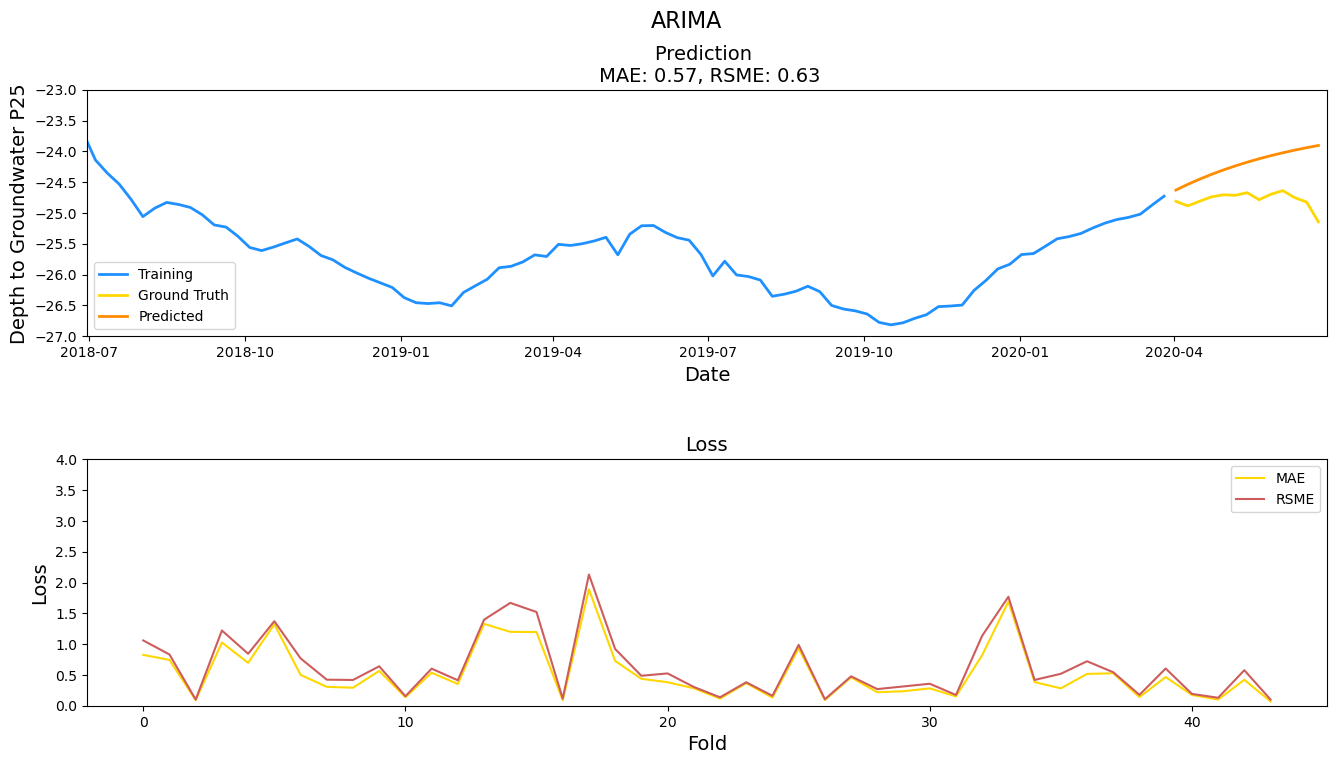

In [10]:
from statsmodels.tsa.arima.model import ARIMA

score_mae = []
score_rsme = []

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    train_index = df1[df1.quarter_idx < valid_quarter_id].index
    valid_index = df1[df1.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Huấn luyện mô hình với Vector Auto Regression (VAR)
    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()
    
    y_valid_pred = model_fit.predict(valid_index[0], valid_index[-1])

    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()

y_pred = model_fit.predict(y.index[-1]+1, y.index[-1] + len(y_test)).reset_index(drop=True)
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'ARIMA')

**Nhận xét:**
- ***Biểu đồ dự đoán***
    - **Tổng quan:** Dự đoán (Predicted, đường màu đỏ) có vẻ hơi lệch so với giá trị thực tế (Ground Truth, đường màu vàng) ở một số điểm, đặc biệt là vào cuối giai đoạn dự báo.
    
    - **Sai số:** Các chỉ số MAE (Mean Absolute Error) và RMSE (Root Mean Square Error) lần lượt là `0.57` và `0.63`, cho thấy sai số dự báo không quá lớn, nhưng cũng không phải là quá nhỏ. Điều này có nghĩa là mô hình dự báo khá tốt, nhưng vẫn có thể cải thiện thêm.

- ***Biểu đồ loss***
    - **Tổng quan:** Cả hai chỉ số đều dao động khá nhiều, đặc biệt là ở những fold đầu tiên. Điều này cho thấy mô hình có thể không ổn định và cần được điều chỉnh thêm.

    - **Điểm đáng chú ý:** Có một điểm đáng chú ý là ở khoảng fold thứ 20, cả MAE và RMSE đều giảm xuống mức thấp nhất. Cho thấy mô hình đã tìm được một tập hợp tham số tốt hơn ở giai đoạn này.

$\longrightarrow$ **Nhận xét chung:** Mô hình ARIMA đã thể hiện khả năng dự báo khá tốt độ sâu của nước ngầm.

### 1.3. Prophet

Là một mô hình dự báo chuỗi thời gian nguồn mở được phát triển bởi **Facebook**. 
- Được thiết kế để dễ sử dụng và có khả năng xử lý các chuỗi thời gian có các đặc điểm phức tạp như xu hướng phi tuyến, tính thời vụ và các ngày lễ.

- ***Cách hoạt động***: Prophet sử dụng một **mô hình cộng (additive model)** để phân tách chuỗi thời gian thành các thành phần khác nhau:
    - **Xu hướng (trend)**: Mô tả sự thay đổi chung của chuỗi thời gian theo thời gian.
    - **Tính thời vụ (seasonality)**: Mô tả các mẫu lặp lại theo chu kỳ trong chuỗi thời gian, chẳng hạn như theo ngày, tuần, tháng hoặc năm.
    - **Các ngày lễ (holidays)**: Mô tả các sự kiện đặc biệt có thể ảnh hưởng đến chuỗi thời gian, chẳng hạn như các ngày lễ hoặc các sự kiện lớn.

$\longrightarrow$ Prophet sử dụng các phương pháp hồi quy và các hàm đặc biệt để mô hình hóa từng thành phần này. Sau đó, nó kết hợp các thành phần này lại để tạo ra dự báo cuối cùng.

13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing
13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing
13:19:25 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1]

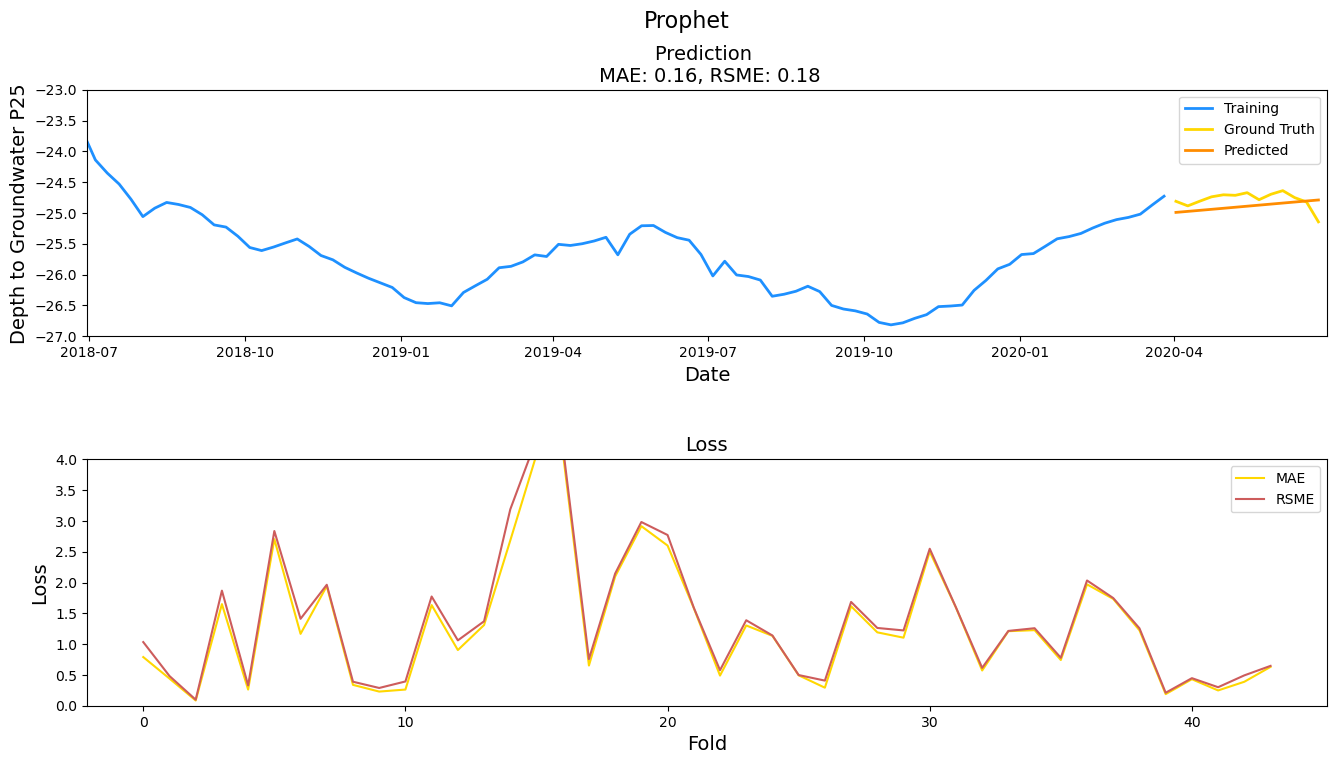

In [11]:
from prophet import Prophet

score_mae = []
score_rmse = []

for valid_quarter_id in range(2, N_SPLITS):
    train_index = df1[df1.quarter_idx < valid_quarter_id].index
    valid_index = df1[df1.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]

    # Kết hợp dữ liệu từ X và y cho Prophet
    train_data = pd.DataFrame({'ds': X_train['Date'], 'y': y_train.values})
    valid_data = pd.DataFrame({'ds': X_valid['Date'], 'y': y_valid.values})

    # Huấn luyện mô hình Prophet
    model = Prophet()
    model.fit(train_data)

    future = valid_data[['ds']]
    forecast = model.predict(future)
    y_valid_pred = forecast['yhat'].values

    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rmse.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

train_data = pd.DataFrame({'ds': X['Date'], 'y': y.values})
model = Prophet()
model.fit(train_data)

future = pd.DataFrame({'ds': pd.date_range(start=X['Date'].iloc[-1], periods=len(y_test) + 1, freq='D')[1:]})
forecast = model.predict(future)
y_pred = forecast['yhat'].values

plot_approach_evaluation(y_pred, score_mae, score_rmse, 'Prophet')


**Nhận xét:**
- ***Khả năng dự đoán của mô hình:***
    - Nhìn chung, mô hình Prophet thể hiện khả năng dự đoán khá tốt về độ sâu mực nước ngầm. Đường dự đoán (màu cam) bám sát gần với giá trị thực tế (màu vàng) trong khoảng thời gian 4/2020 đến hết.
    - Tuy nhiên, có một số thời điểm mô hình dự đoán chưa thực sự chính xác, đặc biệt là vào cuối năm 2019 và đầu năm 2020, khi đường dự đoán có xu hướng lệch lên trên so với giá trị thực tế.

- ***Hiệu suất của mô hình:***
    - Các độ đo MAE (Mean Absolute Error) và RMSE (Root Mean Square Error) đều khá nhỏ (lần lượt là `0.16` và `0.18`), cho thấy sai số dự đoán của mô hình không lớn.
    - Biểu đồ Loss (mất mát) ở phía dưới cho thấy quá trình huấn luyện mô hình diễn ra khá ổn định. Giá trị Loss giảm dần theo số lần lặp (Fold), và các đường MAE và RMSE cũng có xu hướng giảm, thể hiện mô hình đang học và cải thiện khả năng dự đoán qua từng lần lặp.


$\rightarrow$ **Nhận xét chung:**
- Mô hình Prophet cho thấy tiềm năng tốt trong việc dự đoán độ sâu mực nước ngầm. Tuy nhiên, vẫn cần cải thiện độ chính xác của mô hình, đặc biệt là trong việc dự đoán các biến động đột ngột của mực nước.

- Việc phân tích thêm các yếu tố ảnh hưởng đến mực nước ngầm (như lượng mưa, hoạt động khai thác nước,...) có thể giúp cải thiện hiệu suất của mô hình.

- Việc tinh chỉnh các siêu tham số của mô hình Prophet cũng có thể là một hướng tiếp cận để nâng cao khả năng dự đoán.

## 2. Models for Multivariate Time Series - Mô hình hóa Đa biến

### Vector Auto Regression (VAR)

Là **mô hình hồi quy vectơ tự động**, là một mô hình thống kê được sử dụng để nắm bắt mối quan hệ và sự phụ thuộc lẫn nhau giữa nhiều biến số theo thời gian. 
- VAR là một dạng tổng quát của mô hình tự hồi quy (AR) truyền thống, cho phép phân tích đồng thời nhiều chuỗi thời gian.

- ***Công thức:***
$$
y_t = \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \dots + \alpha_p y_{t-p} + u_t
$$
- Trong đó:
    - $y_t$ là một vectơ chứa các giá trị của các biến số tại thời điểm $t$.
    - $\alpha_1, \alpha_2, \dots, \alpha_p$ là các ma trận hệ số mô tả ảnh hưởng của các giá trị quá khứ lên giá trị hiện tại.
    - $p$ là số lượng độ trễ (`lags`) được đưa vào mô hình.
    - $u_t$ là một vectơ chứa các nhiễu loạn ngẫu nhiên.

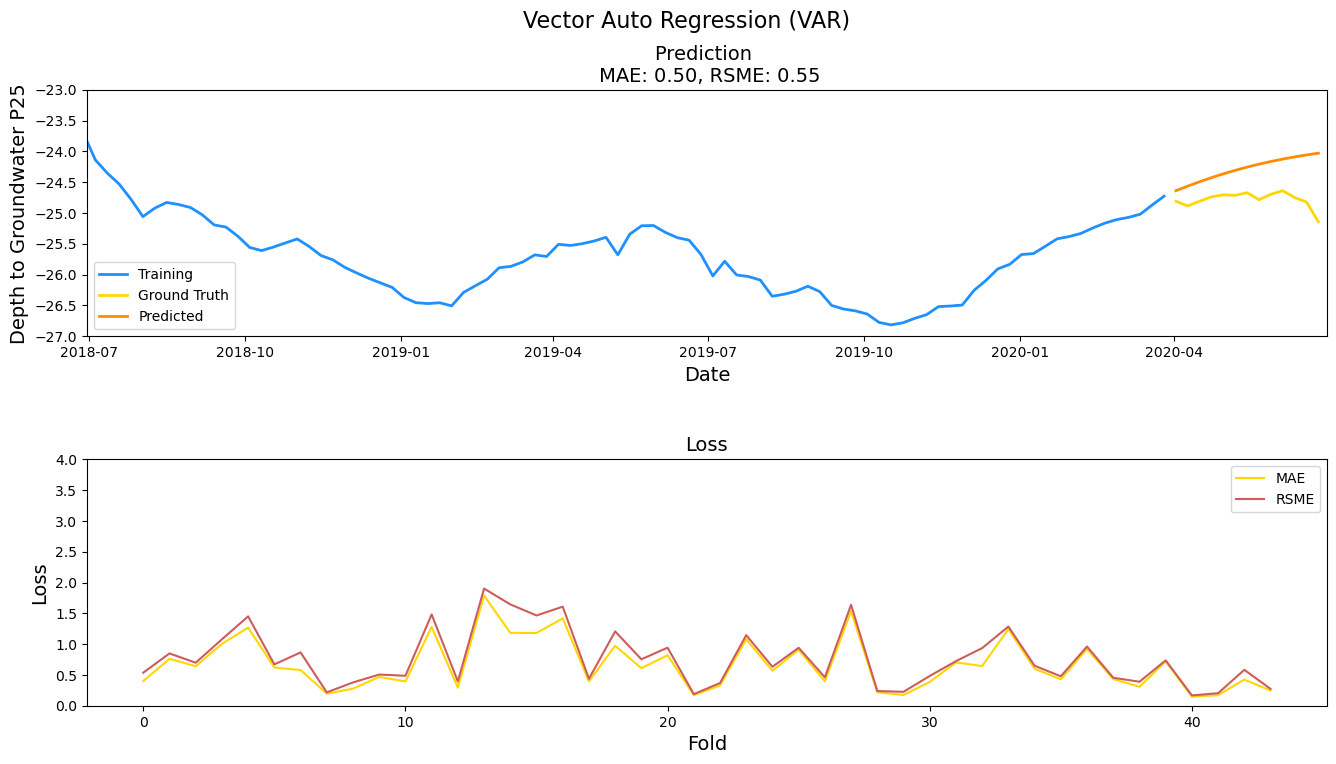

In [17]:
from statsmodels.tsa.api import VAR

score_mae = []
score_rsme = []

features = ['Temperature', 'Drainage_Volume', 'River_Hydrometry', 'Rainfall']

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    train_index = df1[df1.quarter_idx < valid_quarter_id].index
    valid_index = df1[df1.quarter_idx == valid_quarter_id].index

    train_data = pd.concat([y.iloc[train_index], X.iloc[train_index][features]], axis=1)
    valid_data = pd.concat([y.iloc[valid_index], X.iloc[valid_index][features]], axis=1)
    
    # Huấn luyện mô hình với Vector Auto Regression (VAR)
    model = VAR(train_data)
    model_fit = model.fit()

    lag_order = model_fit.k_ar
    forecast_input = train_data.values[-lag_order:]
    y_valid_pred = model_fit.forecast(forecast_input, steps=len(valid_data))
    y_valid_pred = pd.Series(y_valid_pred[:, 0], index=valid_data.index)

    score_mae.append(mean_absolute_error(valid_data[target], y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(valid_data[target], y_valid_pred)))

full_data = pd.concat([y, X[features]], axis=1)
model = VAR(full_data)
model_fit = model.fit()

lag_order = model_fit.k_ar
forecast_input = full_data.values[-lag_order:]
y_pred = model_fit.forecast(forecast_input, steps=len(X_valid))
y_pred = pd.Series(y_pred[:, 0])

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Vector Auto Regression (VAR)')


**Nhận xét:**

- ***Biểu đồ dự đoán:***
    - **Tổng quan:** Dự đoán (Predicted, đường màu đỏ) có vẻ hơi lệch so với giá trị thực tế (Ground Truth, đường màu vàng), đặc biệt là vào cuối giai đoạn dự báo.
    - **Sai số:** Các chỉ số MAE (Mean Absolute Error) và RMSE (Root Mean Square Error) lần lượt là `0.50` và `0.55`, cho thấy sai số dự báo không quá lớn. Điều này có nghĩa là mô hình dự báo khá tốt, nhưng vẫn có thể cải thiện thêm.

- ***Biểu đồ loss:***
    - **Tổng quan:** Cả hai chỉ số đều dao động khá nhiều, đặc biệt là ở những fold đầu tiên. Cho thấy mô hình có thể không ổn định và cần được điều chỉnh thêm.
    - **Điểm đáng chú ý:** Có một điểm đáng chú ý là ở khoảng fold thứ 20, cả MAE và RMSE đều giảm xuống mức thấp nhất. Điều này có thể là một dấu hiệu cho thấy mô hình đã tìm được một tập hợp tham số tốt hơn ở giai đoạn này.